# Import Libraries

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [112]:
seqs_ds = pd.read_excel('SG-20-0106_0M_kinetics_training.xlsx')

In [113]:
seqs_ds

,well,0_min,30_min,60_min,90_min,120_min,150_min,180_min,210_min,240_min
0,A1,621,894,1021,1097,1203,1378,1559,1765,1973
1,A2,624,908,984,980,1025,1168,1291,1478,1690
2,A3,680,1081,1199,1293,1423,1635,1807,2021,2252
3,A4,632,1000,1058,1116,1210,1374,1523,1722,1959
4,A5,744,1069,1162,1138,1168,1208,1315,1441,1604
...,...,...,...,...,...,...,...,...,...,...
91,H8,481,827,953,1041,1102,1185,1283,1412,1549
92,H9,635,949,1094,1299,1573,1887,2351,2795,3368
93,H10,541,757,921,1229,1635,2156,2723,3459,4133
94,H11,645,845,978,1158,1298,1572,1891,2307,2796


In [114]:
encoded_seqs = seqs_ds.values[:, 1:]

In [115]:
encoded_seqs.shape

(96, 9)

In [116]:
encoded_seqs = encoded_seqs.astype(int)

In [117]:
encoded_seqs.shape

(96, 9)

In [118]:
encoded_seqs

array([[ 621,  894, 1021, 1097, 1203, 1378, 1559, 1765, 1973],
       [ 624,  908,  984,  980, 1025, 1168, 1291, 1478, 1690],
       [ 680, 1081, 1199, 1293, 1423, 1635, 1807, 2021, 2252],
       [ 632, 1000, 1058, 1116, 1210, 1374, 1523, 1722, 1959],
       [ 744, 1069, 1162, 1138, 1168, 1208, 1315, 1441, 1604],
       [ 668,  967, 1104, 1134, 1209, 1304, 1447, 1609, 1827],
       [ 574,  879, 1046, 1159, 1343, 1587, 1860, 2157, 2482],
       [ 533,  755,  992, 1201, 1387, 1571, 1780, 2050, 2288],
       [ 553,  806,  993, 1210, 1465, 1818, 2210, 2668, 3165],
       [ 569,  767,  920, 1108, 1264, 1541, 1820, 2138, 2505],
       [ 555,  774,  987, 1120, 1335, 1601, 1962, 2363, 2862],
       [ 556,  868,  946, 1082, 1258, 1497, 1803, 2196, 2637],
       [ 575,  844,  963, 1033, 1135, 1331, 1530, 1739, 1959],
       [ 554,  844,  902,  927,  969, 1043, 1132, 1253, 1416],
       [ 599,  895,  964, 1006, 1046, 1122, 1281, 1420, 1591],
       [ 564,  914,  951,  939,  972, 1024, 1132, 1206,

In [119]:
#encoded_seqs = encoded_seqs.reshape(-1, 1)

In [120]:
# Scale our data using a MinMaxScaler that will scale
# each number so that it will be between 0 and 1
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer

# Scale data
scaler = MinMaxScaler()
scaled_seqs = scaler.fit_transform(encoded_seqs)

#scaler = StandardScaler()
#scaled_seqs = scaler.fit_transform(encoded_seqs)

#scaler = RobustScaler()
#scaled_seqs = scaler.fit_transform(encoded_seqs)

#scaler = PowerTransformer()
#scaled_seqs = scaler.fit_transform(encoded_seqs)

#scaler = QuantileTransformer()
#scaled_seqs = scaler.fit_transform(encoded_seqs)

# Create a test and train sets of our data
x_train = scaled_seqs
#x_test = scaled_seqs[75:]

# np.random.shuffle(X_train)
# np.random.shuffle(X_test)

In [121]:
x_train.shape

(96, 9)

In [257]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras import optimizers
from keras.callbacks import EarlyStopping

input_dim = x_train.shape[1] # the # features
encoding_dim = 8 # first layer
#hidden_dim = int(encoding_dim / 2) #hideen layer
hidden_dim = 3


nb_epoch = 1000
batch_size = 32
learning_rate = 0.001

# input_layer = Input(shape=(input_dim, ))
# encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
# encoder = Dense(hidden_dim, activation="relu")(encoder)
# decoder = Dense(encoding_dim, activation='relu')(encoder)
# decoder = Dense(input_dim, activation='tanh')(decoder)
# autoencoder = Model(inputs=input_layer, outputs=decoder)

input_layer = Input(shape=(input_dim, ))
encoder = Dense(64, activation="relu", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(32, activation="relu")(encoder)
encoder = Dense(3, activation="relu")(encoder)
decoder = Dense(32, activation='relu')(encoder)
decoder = Dense(64, activation='relu')(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

optimizer = optimizers.Adam(lr=0.001)

autoencoder.compile(optimizer=optimizer, 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model_bin.h5",
                               verbose=0,
                               save_best_only=True)

early_stop = EarlyStopping(monitor='loss', patience=3)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(x_train, x_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(x_train, x_train),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard, early_stop]).history

Epoch 1/1000
3/3 [==============================] - 0s 100ms/step - loss: 0.1624 - accuracy: 0.2708 - val_loss: 0.1584 - val_accuracy: 0.2188
Epoch 2/1000
3/3 [==============================] - 0s 25ms/step - loss: 0.1554 - accuracy: 0.2604 - val_loss: 0.1473 - val_accuracy: 0.3438
Epoch 3/1000
3/3 [==============================] - 0s 24ms/step - loss: 0.1424 - accuracy: 0.3125 - val_loss: 0.1311 - val_accuracy: 0.2708
Epoch 4/1000
3/3 [==============================] - 0s 24ms/step - loss: 0.1242 - accuracy: 0.2708 - val_loss: 0.1111 - val_accuracy: 0.2708
Epoch 5/1000
3/3 [==============================] - 0s 24ms/step - loss: 0.1034 - accuracy: 0.2708 - val_loss: 0.0895 - val_accuracy: 0.2708
Epoch 6/1000
3/3 [==============================] - 0s 26ms/step - loss: 0.0830 - accuracy: 0.2708 - val_loss: 0.0683 - val_accuracy: 0.2708
Epoch 7/1000
3/3 [==============================] - 0s 25ms/step - loss: 0.0619 - accuracy: 0.2708 - val_loss: 0.0489 - val_accuracy: 0.2708
Epoch 8/1000

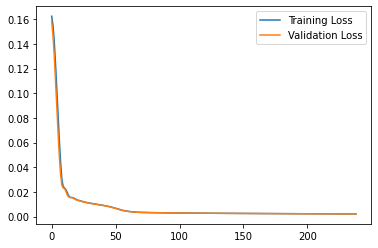

In [258]:
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.legend()

In [259]:
print(f'Min Loss:{np.min(history["loss"])}')

Min Loss:0.0022254332434386015


In [260]:
seqs_ds = pd.read_excel('SG-20-0107-kinetic_blind_LOD_testing.xlsx')

In [261]:
seqs_ds = seqs_ds

In [262]:
seqs_ds.shape

(96, 10)

In [263]:
#test_seqs = test_seqs.drop('0_min', axis=1)

In [264]:
encoded_seqs = seqs_ds.values[:, 1:]

In [265]:
encoded_seqs

array([[729, 885, 1032, 1197, 1335, 1535, 1785, 2113, 2459],
       [698, 843, 964, 1058, 1150, 1289, 1430, 1667, 1962],
       [673, 861, 959, 1053, 1138, 1185, 1282, 1417, 1594],
       [651, 761, 918, 1025, 1195, 1315, 1458, 1648, 1902],
       [798, 873, 998, 1293, 1451, 1604, 1853, 2131, 2477],
       [805, 883, 1124, 1331, 1474, 1675, 1839, 2109, 2429],
       [961, 1276, 1496, 1712, 1969, 2209, 2430, 2811, 3234],
       [710, 1018, 1131, 1366, 1659, 2052, 2538, 3041, 3675],
       [684, 979, 1211, 1445, 1799, 2199, 2698, 3282, 3906],
       [689, 1005, 1146, 1316, 1560, 1908, 2333, 2810, 3375],
       [712, 999, 1161, 1407, 1755, 2194, 2802, 3482, 4261],
       [615, 864, 981, 1121, 1341, 1611, 1980, 2398, 2862],
       [633, 835, 989, 1150, 1295, 1525, 1737, 1963, 2325],
       [652, 835, 940, 1056, 1178, 1358, 1482, 1707, 1984],
       [686, 879, 995, 1099, 1220, 1332, 1436, 1660, 1947],
       [570, 645, 806, 954, 1102, 1320, 1525, 1759, 2024],
       [772, 878, 1177, 1357, 1

In [266]:
encoded_seqs = encoded_seqs.astype(int)

In [267]:
#encoded_seqs = encoded_seqs.reshape(-1, 1)

In [268]:
encoded_seqs.shape

(96, 9)

In [269]:

# scale data
scaled_data = MinMaxScaler().fit_transform(encoded_seqs)
# scaled_data = RobustScaler().fit_transform(encoded_seqs)
#scaled_data = StandardScaler().fit_transform(encoded_seqs)
#scaled_data = PowerTransformer().fit_transform(encoded_seqs)
# scaled_data = QuantileTransformer().fit_transform(encoded_seqs)
# scaled_data = scaler.transform(encoded_seqs)

# Predict it
predicted = autoencoder.predict(scaled_data)

# Get the error term
mse = np.mean(np.power(scaled_data - predicted, 2), axis=1)

# Now add them to the data frame
seqs_ds['MSE'] = mse

In [270]:
mse_threshold = np.quantile(seqs_ds['MSE'], 0.5)
print(f'MSE 0.9998 threshold:{mse_threshold}')

MSE 0.9998 threshold:0.0050271600480258204


In [271]:
seqs_ds['MSE_Outlier'] = 0
seqs_ds.loc[seqs_ds['MSE'] > mse_threshold, 'MSE_Outlier'] = 1

In [272]:
print(f"Num of MSE outliers:{seqs_ds['MSE_Outlier'].sum()}")
seqs_ds.loc[seqs_ds['MSE_Outlier'] == 1]

Num of MSE outliers:48


,well,0_min,30_min,60_min,90_min,120_min,150_min,180_min,210_min,240_min,MSE,MSE_Outlier
4,A5,798,873,998,1293,1451,1604,1853,2131,2477,0.012752,1
5,A6,805,883,1124,1331,1474,1675,1839,2109,2429,0.010107,1
6,A7,961,1276,1496,1712,1969,2209,2430,2811,3234,0.012615,1
7,A8,710,1018,1131,1366,1659,2052,2538,3041,3675,0.010628,1
8,A9,684,979,1211,1445,1799,2199,2698,3282,3906,0.007736,1
9,A10,689,1005,1146,1316,1560,1908,2333,2810,3375,0.007087,1
10,A11,712,999,1161,1407,1755,2194,2802,3482,4261,0.018334,1
16,B5,772,878,1177,1357,1561,1754,1954,2220,2599,0.007472,1
17,B6,822,1050,1211,1389,1564,1773,1980,2268,2614,0.008703,1
18,B7,985,1114,1504,1708,1855,2079,2296,2549,2928,0.011652,1


In [141]:
# seqs_ds['well'] = test_seqs['well'])

In [142]:
seqs_ds.loc[seqs_ds['MSE_Outlier'] == 1]

,well,0_min,30_min,60_min,90_min,120_min,150_min,180_min,210_min,240_min,MSE,MSE_Outlier
2,A3,673,861,959,1053,1138,1185,1282,1417,1594,0.003985,1
4,A5,798,873,998,1293,1451,1604,1853,2131,2477,0.003756,1
6,A7,961,1276,1496,1712,1969,2209,2430,2811,3234,0.006217,1
7,A8,710,1018,1131,1366,1659,2052,2538,3041,3675,0.006799,1
8,A9,684,979,1211,1445,1799,2199,2698,3282,3906,0.005245,1
9,A10,689,1005,1146,1316,1560,1908,2333,2810,3375,0.003790,1
10,A11,712,999,1161,1407,1755,2194,2802,3482,4261,0.009817,1
17,B6,822,1050,1211,1389,1564,1773,1980,2268,2614,0.003163,1
18,B7,985,1114,1504,1708,1855,2079,2296,2549,2928,0.005802,1
19,B8,619,711,791,1188,1448,1868,2242,2701,3338,0.011296,1


In [ ]:
seqs_ds[['MSE_Outlier', 'well']].to_csv('predictions.csv')